<a href="https://colab.research.google.com/github/FelipeFerAl/TAM-2025-2/blob/main/ClassExercises/EjerciciosCuaderno7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ejercicio 1

In [1]:
from IPython.display import clear_output

# Importar todas las librerias necesarias instalando RAPIDS en el entorno Colab
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

#Importar imagen
FILEID = "1KENM6BW5UjRoSjnWmuBP_MS_NrC0cefP"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O tanjiro.jpeg && rm -rf /tmp/cookies.txt

import cv2
import cudf
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from cuml.cluster import KMeans, DBSCAN
from sklearn.cluster import SpectralClustering
from cuml.metrics.cluster import silhouette_score

clear_output()

In [2]:
image_cpu = cv2.imread("tanjiro.jpeg")
image_cpu = cv2.cvtColor(image_cpu, cv2.COLOR_BGR2RGB)  # convert to RGB

image = cp.asarray(image_cpu)
image_small = cv2.resize(image_cpu, (100, 100), interpolation=cv2.INTER_AREA)
image_small_gpu = cp.asarray(image_small)

print(type(image))
print(image.shape)

<class 'cupy.ndarray'>
(225, 225, 3)


In [3]:
# --- Load & reshape image ---
r, c, ch = image.shape
pixels = image.reshape(-1, 3).astype(cp.float32)

# --- Add spatial coordinates ---
ys_flat = cp.repeat(cp.arange(r), c)[:, None]
xs_flat = cp.tile(cp.arange(c), r)[:, None]
coords = cp.hstack([xs_flat, ys_flat]).astype(cp.float32)

# Combine [R, G, B, x, y]
X = cp.hstack([pixels, coords])

# Convert to cuDF for RAPIDS clustering
X_df = cudf.DataFrame(X, columns=["R", "G", "B", "x", "y"])

# --- Parameters ---
kmeans_group = [3, 5, 7, 9]
results = []

# --- KMeans comparison ---
for k in kmeans_group:
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(X_df)
  labels = kmeans.labels_

  inertia = float(kmeans.inertia_)  # only KMeans has inertia
  sil = float(silhouette_score(X_df, labels))
  results.append(("KMeans", k, inertia, sil))

In [4]:
# --- DBSCAN ---
dbscan = DBSCAN(eps=20, min_samples=10)
labels_db = dbscan.fit_predict(X_df)
sil_db = float(silhouette_score(X_df, labels_db))
results.append(("DBSCAN", "-", None, sil_db))

[2025-10-26 14:50:46.056] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 50016 -> 42419. Using the larger integer type might result in better performance


   Method  k      Inertia  Silhouette
0  KMeans  3  360555584.0    0.365001
1  KMeans  5  201570176.0    0.439510
2  KMeans  7  124719760.0    0.455462
3  KMeans  9   99502176.0    0.418630
4  DBSCAN  -          NaN   -0.029952


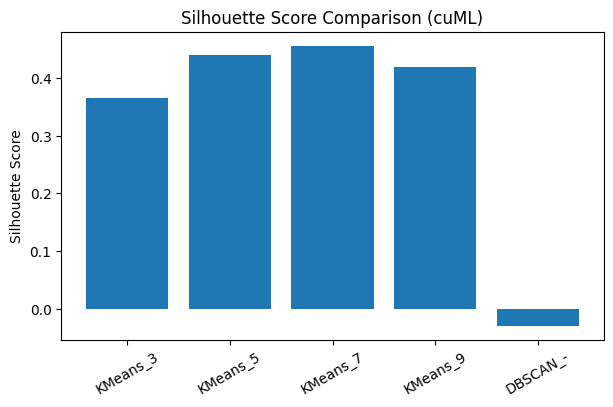

In [5]:
# --- Show results ---
import pandas as pd
df_results = pd.DataFrame(results, columns=["Method", "k", "Inertia", "Silhouette"])
print(df_results)

# --- Plot Silhouette comparison ---
plt.figure(figsize=(7,4))
plt.bar(df_results["Method"].astype(str) + "_" + df_results["k"].astype(str), df_results["Silhouette"])
plt.title("Silhouette Score Comparison (cuML)")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=30)
plt.show()

#Ejercicio 2

In [6]:
from cuml.manifold import UMAP
import cupyx.scipy.sparse as sp
from cuml.decomposition import PCA
import cupyx.scipy.sparse.linalg as spla
from cuml.neighbors import NearestNeighbors

pca_2d = PCA(n_components=2)
X_pca = pca_2d.fit_transform(X)

umap_2d = UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X_umap = umap_2d.fit_transform(X)

[2025-10-26 14:50:46.850] [CUML] [info] Building knn graph using nn descent (configured from build_algo='auto')


In [7]:
# --- Parameters ---
projections = {'PCA': X_pca, 'UMAP': X_umap}
kmeans_group = [3, 5, 7, 9]
results2 = []

# --- KMeans comparison ---
for proj_name, X_proj in projections.items():
  for k in kmeans_group:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_proj)
    labels = kmeans.labels_

    inertia = float(kmeans.inertia_)  # only KMeans has inertia
    sil = float(silhouette_score(X_proj, labels))
    results2.append(("KMeans", proj_name,k, inertia, sil))

In [8]:
# --- DBSCAN ---
for proj_name, X_proj in projections.items():
  dbscan = DBSCAN(eps=20, min_samples=5)
  labels_db = dbscan.fit_predict(X_proj)

  unique_labels = np.unique(cp.asnumpy(labels))
  valid_labels = unique_labels[unique_labels != -1]
  if len(valid_labels) > 1:
      sil = float(silhouette_score(cp.asnumpy(X_proj), cp.asnumpy(labels)))
  else:
      sil = -1  # invalid silhouette
  results2.append(("DBSCAN", proj_name, None, sil))

[2025-10-26 14:50:52.775] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 50020 -> 42419. Using the larger integer type might result in better performance
[2025-10-26 14:50:53.360] [CUML] [info] Batch size limited by the chosen integer type (4 bytes). 50020 -> 42419. Using the larger integer type might result in better performance


   Method Projection    k       Inertia  Silhouette
0  KMeans        PCA  3.0  1.415644e+08    0.548138
1  KMeans        PCA  5.0  7.395066e+07    0.573627
2  KMeans        PCA  7.0  5.774802e+07    0.556651
3  KMeans        PCA  9.0  3.088499e+07    0.562145
4  KMeans       UMAP  3.0  1.718285e+06    0.419178
5  KMeans       UMAP  5.0  1.103102e+06    0.360919
6  KMeans       UMAP  7.0  7.445535e+05    0.390069
7  KMeans       UMAP  9.0  5.364282e+05    0.409273
8  DBSCAN        PCA  NaN -1.742386e-01         NaN
9  DBSCAN       UMAP  NaN  4.092734e-01         NaN


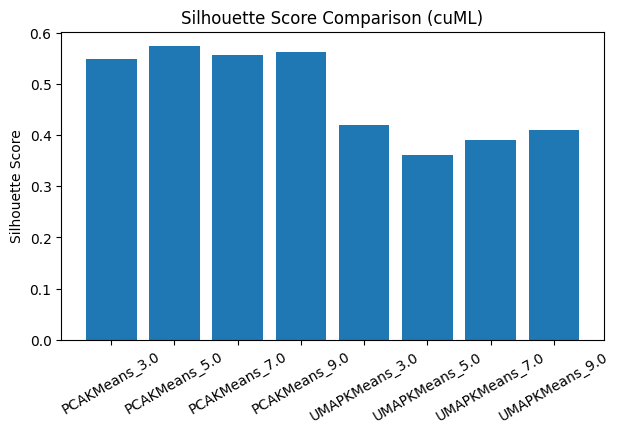

In [9]:
df_results2 = pd.DataFrame(results2, columns=["Method", "Projection", "k", "Inertia", "Silhouette"])
print(df_results2)

plt.figure(figsize=(7,4))
plt.bar(df_results2["Projection"].astype(str)+df_results2["Method"].astype(str) + "_" + df_results2["k"].astype(str), df_results2["Silhouette"])
plt.title("Silhouette Score Comparison (cuML)")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=30)
plt.show()